In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
vocab_size

27

In [14]:
#build the dataset
block_size = 3 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words[:]:
        #print(f'Word: {w}')
        context = [0] * block_size 
        ##print(''.join(str(context)))
        for ch in w + '.':
            ix = stoi[ch]
            #print(f'ix: {ix}')
            X.append(context)
            Y.append(ix)
            ##print('Appended context into X and ix into Y')
            context = context[1:] + [ix] #crop and append
            #print(''.join(str(context)))

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    #print(X)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [15]:
#Boilerplate from the batchnorm version above this comment

#Utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t): 
    ex = torch.all(dt == t.grad).item() #Check for exact equality
    app = torch.allclose(dt, t.grad) #Check for approximate equality (allclose() uses epsilons for comparison)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [16]:
#MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),  generator=g)
#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #Kaiming init: Gain for tanh / sqrt of fan-in number of neurons
b1 = torch.randn(n_hidden, generator=g) * 0.1 #using b1 just for fun, to check if we're still calculating the right gradient for this even though its useless

#Layer 2
W2 = torch.randn((n_hidden, vocab_size),  generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

#Batchnorm parameters
bngain = torch.ones((1, n_hidden)) *0.1 + 1.0
bnbias = torch.zeros((1, n_hidden))*0.1 

#Parameters are being initialized in with smaller values because sometimes initializing with
#all zeroes can mask an incorrect implementation of the backward pass

#bnmean_running = torch.zeros((1, n_hidden))
#bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [17]:
batch_size = 32
n = batch_size #a shorter variable for convenience
#construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

In [18]:
#forward pass, "chunckated" into smaller steps that possible to backward pass one at a time

emb = C[Xb] #embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) #concatenate the vectors

#Linear Layer 1
hprebn = embcat @ W1 + b1 #hidden layer pre-batch-norm 

#BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) #note: Bessel's correction (dividing by n-1, not n) see https://www.statisticshowto.com/bessels-correction/
bnvar_inv = (bnvar+1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias #hidden layer pre-activation

#Non-linearity
h = torch.tanh(hpreact) #hidden layer

#Linear Layer 2
logits = h @ W2 + b2

#Cross Entropy Loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 #if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact
probs = counts * counts_sum_inv
logprobs = probs.log() #Batch of inputs and the probability they output a specific letter. 32 x 27
loss = -logprobs[range(n), Yb].mean() #Extract the loss calculated for the corresponding letter of Yb and calculate the mean across all the extracted values
#print(f'logprobs: {logprobs}')
#print(f'logprobs[range(n), ]: {logprobs[range(n), ]}')
#print(f'Yb: {Yb}')
#print(f'logprobs[range(n), Yb]: {logprobs[range(n), Yb]}')

#PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss



tensor(3.5116, grad_fn=<NegBackward0>)

In [19]:
#For dlogprobs where dloss/dlogprobs is the derivative of loss
#with respect to ALL elements in logprobs
#therefore, dlogprobs will have the same shape as logprobs (32, 7)

#Consider that the loss = (a + b + c)/3 where logprobs comprises elements a, b, c
#dloss/da is then = (1 + b + c)/3
#It follows then that dloss/dlogprobs = 1/3, or more generally 1/n

#Since we also do a selection for logprobs [range(n), Yb] 
#we only want elements that contributed to the loss to have a gradient
#To do this, we can just create a new tensor with the same as logprobs
#initialised to all zeroes, and then set the same indices to our gradient

#For dcounts_sum_inv
#The local derivative is the same as if we have f(x,y) = xy, therefore df/dx = y
#However, we need to take into account the shapes of counts and counts_sum_inv,
#(32,27) and 32,1 respectively.
#What this means is that we need to backprop through and differentiate the hidden
#PyTorch broadcast during matrix multiplication 
#Consider the example:
#c = a @ b
#a[3x3] * b[3,1] ---> Multiplication would then look like bc b1 is a column vector
#a11*b1, a12*b1, a13*b1
#a21*b2, a22*b2, a33*b2
#a31*b3, a32*b3, a33*b3
#The operation that needs backprop is the many multiplications of an a[] column with a b vector
#This can be handled by summing all the gradients of dc/db and we do so horizontally

#For dlogit_maxes
#Similar to dcount_sum_inv, need to consider the shape
#But otherwise it's just the sum of local derivative

In [55]:
logit_maxes.shape, logits.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [62]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = 1.0/probs*dlogprobs

dcounts_sum_inv = (counts  * dprobs).sum(1, keepdims=True)

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

dcounts = torch.ones_like(counts) * dcounts_sum + counts_sum_inv * dprobs

dnorm_logits = norm_logits.exp() * dcounts

dlogit_maxes = (- dnorm_logits).sum(1, keepdim=True)

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [ ]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = None # TODO. my solution is 3 lines
# -----------------

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

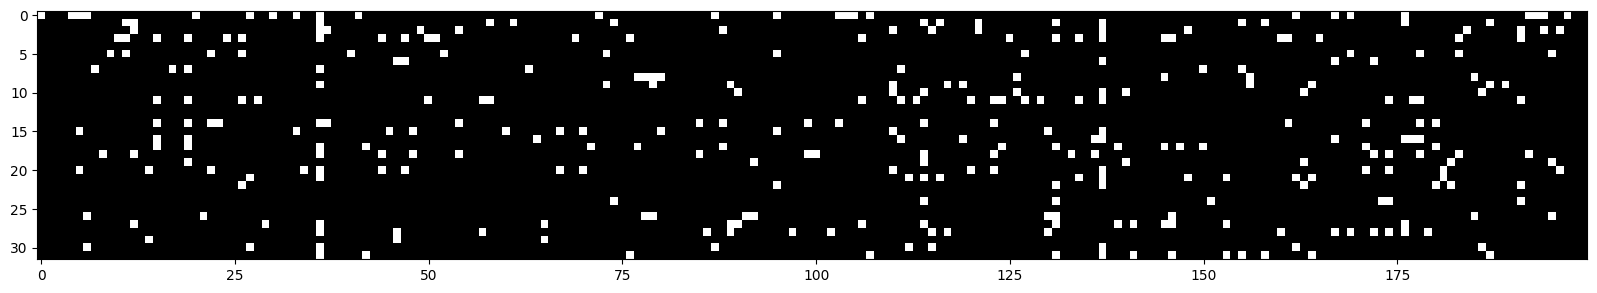

In [12]:
#Plotting of the tanh layer and seeing how many were at the extreems of -1 and 1
#A mostly black figure with some white dots indicates a healthy distribution
#A white column indicates a braindead neuron that is incapable of learning
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

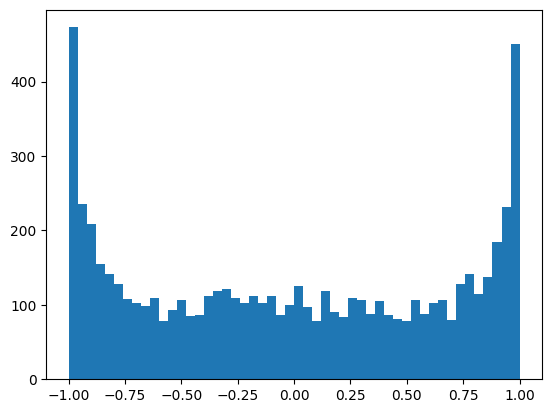

In [13]:
plt.hist(h.view(-1).tolist(), 50);

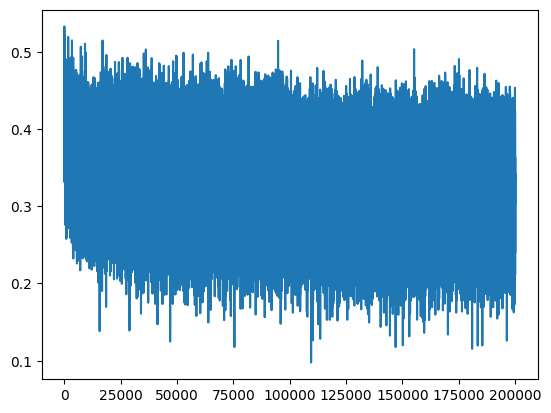

In [14]:
plt.plot(lossi)

In [41]:
#calibrate the batch normalisation at the end of training
#by finding the mean and std.dev over the entire training set
#therefore eliminating the need for training using batches
#The mean and std.dev are also locked at specific values doing this i.e. no updating
#This is optional if the mean and std.dev of the training set are going to be estimated during
#batch training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std.dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    #Depreacted code: hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias 
    #New way of normalising the preactivation layer without batches
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.298912763595581
val 3.2522754669189453


In [11]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size #initialise with all ellipsis
    while True:
        #forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 )#+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.', token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

mrravgmyazhreelmnd.
fyllorethrnghjdrammraxleyd.
mlingellorenledgigvangxarvellzimrlkerin.
shubrrghhiriel.
kjadr.
julizxnthulmoubrbycdar.
jadul.
mhs.
kmajmusthyla.
hyl.
sadylisuf.
zakhlvon.
mmyn.
brisvevongenghdir.
brxondengbprillsh.
geyma.
hmrerlling.
jam.
gvondwella.
lltzellz.


In [23]:
#Repeated but torchified i.e. resembles the existing pytorch library

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html and https://www.youtube.com/watch?v=4gal2zIjm3M

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backpropagation, affine is set to True here)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_Var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 #the dimensionality of the character-embedding vectors
n_hidden = 100 #the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),    generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    #layers[-1].weight *= 0.1 <-- does not use batchnorm
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters total
for p in parameters:
    p.requires_grad = True

47551


In [24]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update:data ratio

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the embed vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()  #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None #Removes current grad so that it doesn't get added onto the grad that's calculated in the next line
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step rate learning decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

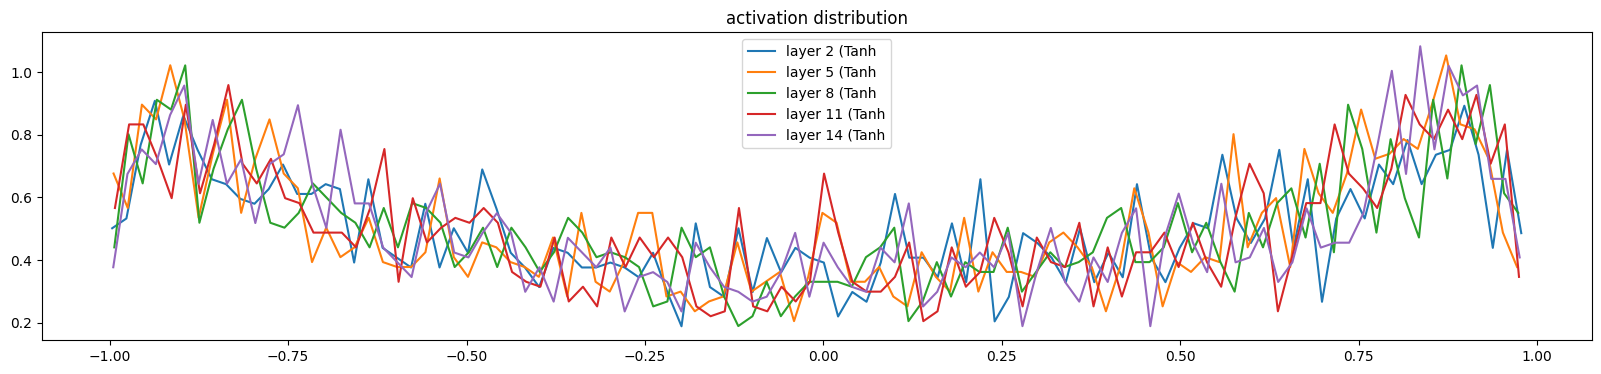

In [25]:
#visualise histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')
#Each layer's distribution should be about equal so that we don't have vanishing or exploding gradients - same gradients

weight   (27, 10) | mean +0.000000 | std8.198653e-03 | grad:data ratio 8.190295e-03
weight  (30, 100) | mean -0.000195 | std7.650395e-03 | grad:data ratio 2.447697e-02
weight (100, 100) | mean -0.000097 | std6.207573e-03 | grad:data ratio 3.712876e-02
weight (100, 100) | mean +0.000015 | std5.561920e-03 | grad:data ratio 3.297629e-02
weight (100, 100) | mean +0.000008 | std5.220602e-03 | grad:data ratio 3.110152e-02
weight (100, 100) | mean +0.000029 | std4.829160e-03 | grad:data ratio 2.876368e-02
weight  (100, 27) | mean -0.000014 | std9.281213e-03 | grad:data ratio 5.568816e-02


Text(0.5, 1.0, 'weights gradient distribution')

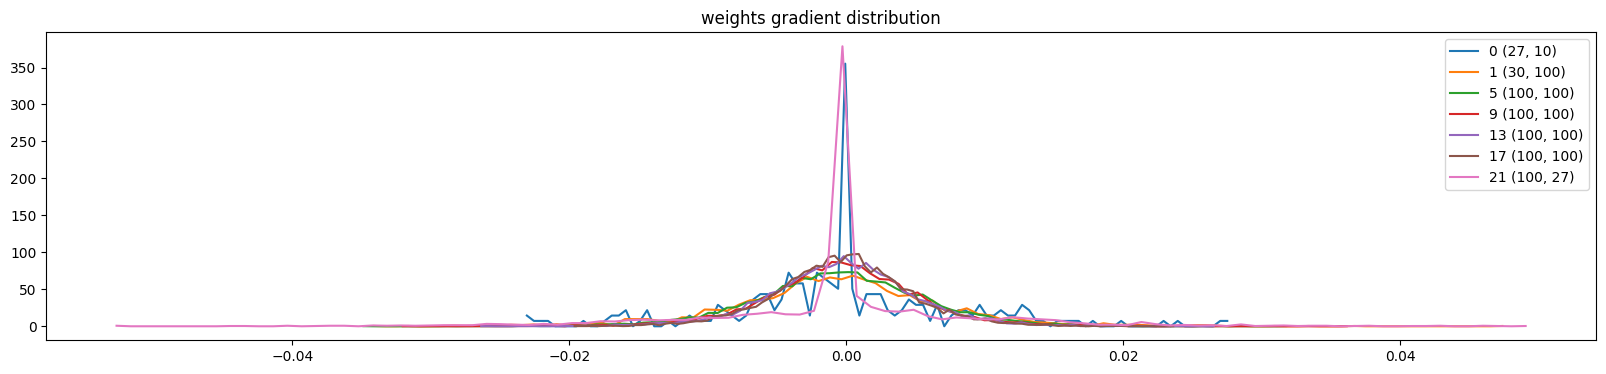

In [26]:
#visualise histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends=[]
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: #Restricting to 2d parameters, i.e. the weights of the linear layers - skipping bias, gammas, betas and batchnorms
        print('weight %10s | mean %+f | std%e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(),t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')


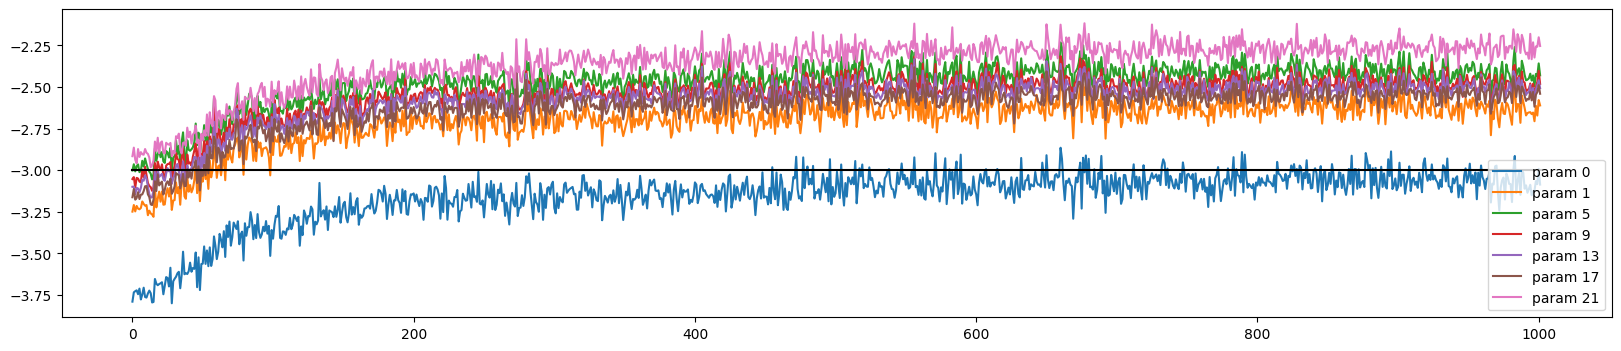

In [27]:
#visualise histograms
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim ==2:
        plt.plot([ud [j] [i] for j in range(len(ud))]) #plot all update ratios over time
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') #these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
